In [14]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()
import regex as re 
# import random
from collections import Counter
import pprint as pp
from see import see 
import nltk
# conda install -c conda-forge wordcloud
# from wordcloud import WordCloud

In [29]:
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# read pickled DF from notebook #1 (initial exploratory data visuals)
df = pd.read_pickle('df_un_general_debates.pkl')

==X== 
* ... 

* Due to the nature of the content, each country is allowed to only deliver a single speech each year
    * Thus, it is quite likely that different paragraphs within the speeches are separated by paragraphs
    * Accordingly, these paragraphs quite likely have different topics
    
* Also raises the issue of formatting issues with how do we define beginning, ends etc. of paragraphs 

In [7]:
# let's recall the same example from notebook #2
# example 1 
df.iloc[0]['text'][0:500]

'33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work on the agenda of the twenty- fifth session of the General Assembly, which is being held on the eve of the twenty-fifth anniversary of the coming into force of the Charter of the United Nations, the peace-loving Member States would have wished to be in a position to present on this occasion some pict'

In [12]:
# e.g. #2
df.iloc[4729]["text"][0:200]

'\ufeffOn behalf of the State of Kuwait, it\ngives me pleasure to congratulate Mr. Han Seung-soo,\nand his friendly country, the Republic of Korea, on his\nelection as President of the fifty-sixth session of t'

* There are newline characters being used to separate prargraphs in the first example
* But in the 2nd example below, newline characters used to separate lines

#### Thus, we need another method to discern the paragraphs 
* E.G. try splitting at stops, exclamation marks, question marks etc. 

In [15]:
# \s* = zero or more whitespace chars 

# define the number of paragraphs of the text, splitting on the punctuation and ignoring the whitespace after them
df["paragraphs"] = df["text"].map(lambda text: re.split('[.?!]\s*\n', text))

In [17]:
# define number of paragraphs by country by mapping the len function
df["number_of_paragraphs"] = df["paragraphs"].map(len)

In [19]:
# E.G. 
df.head(2)

,session,year,country,country_name,speaker,position,text,length,tokens,len_tokens,paragraphs,number_of_paragraphs
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,51419,"[may, first, convey, president, congratulation...",4125,[33: May I first convey to our President the c...,60
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...,29286,"[fortunate, coincidence, precisely, time, unit...",2327,[177.\t : It is a fortunate coincidence that p...,50


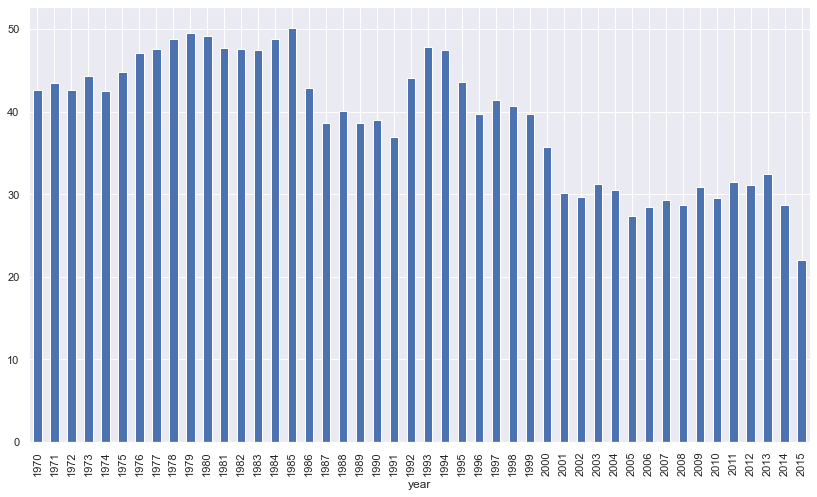

In [28]:
# for curiosity, does the number of paragraphs change over time?
## as we noted before, avg words had decreased as num_countries went up -- so we somewhat expect the same
df.groupby('year')['number_of_paragraphs'].mean().plot.bar(figsize=(14,8));

## TOPIC MODELING PREPARATIONS
* Start with document-term matrix
    * matrix with elements as word frequencies (often tf-idf scaled weights)
        * of the words (columns) in the corresponding documents (rows)
    * The matrix is sparse, as most docs contain only a fraction of the total vocabulary

In [30]:
# re-construct stopwords with additional corpus-specific elements (from notebook #2) to pass into tfidf_vectoriser 
stopwords = set(nltk.corpus.stopwords.words('english'))

In [31]:
# make manual adjustments 
additional_stopwords = {'dear','regards','also','would','must'}
exclude_stopwords = {'against'}

# user set operators to add or remove these elements from our base collection
stopwords |= additional_stopwords

## use the set difference to remove these words 
stopwords -= exclude_stopwords 

### TF-IDF VECTORISER
* `min_df` = when building vocab, ignore terms with a document fequency lower than this threshold (AKA cut-off value)
    * this value represents proportion of documents if float between (0.0, 1.0)
    * Else, absolute counts if integer 
* `max_df` = the inverse, ignore terms with highr than this threshold (akin to: corpus specific stop-words)
    * same rules apply for float/integer 
* `smooth_idf` = adding 1 to document term frequencies (same as notebook #2) 
* `ngram_range` = different n-grams extraction:
    * (1, 1) = only unigrams
    * (1, 2) = unigrams and bigrams
    * (2, 2) = only bigrams etc. 
    
    
    
#### First iteration: start with just uni-grams

In [41]:
## tf-idf vectoriser for speech's text: ##

## start with just unigrams 
tfidf_text_vectorizer_unigrams = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7, smooth_idf = True, 
                                       ngram_range=(1,1))

In [ ]:
## with bigrams



In [38]:
tfidf_text_vectors.shape

(7507, 340767)

In [43]:
%%time 

tfidf_text_vectors = tfidf_text_vectorizer_unigrams.fit_transform(df['text'])

Wall time: 12.7 s


In [44]:
tfidf_text_vectors.shape

(7507, 24747)

#### Repeat for the paragraphs 
* slightly more challenging, must "flatten" each praragraph to it's own row + keep the right reference to its respective year 
* empty paragraphs are omitted 

In [54]:
# if we want to keep the country variable too
## perhaps test in subsequent iteration 
""" 
paragraph_df_by_country = pd.DataFrame([{ "text": paragraph, "year": year, "country": country} 
                               for paragraphs, year, country in zip(df["paragraphs"], df["year"], df["country"]) 
                                    for paragraph in paragraphs if paragraph])
                        
"""

In [45]:
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year } 
                               for paragraphs, year in zip(df["paragraphs"], df["year"]) 
                                    for paragraph in paragraphs if paragraph])

In [50]:
df['number_of_paragraphs'].sum()

287346

In [57]:
# E.G. can see the length of this DF is roughly equivalent to number_of_paragraphs total (less a few for removing empty ones)
paragraph_df.shape

(282210, 2)

In [58]:
# apply tf-idf vectoriser to paragraphs; same min and max params
tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)

In [59]:
%%time 

tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])

Wall time: 14.4 s


In [60]:
tfidf_para_vectors.shape

(282210, 25324)

* NOTE: the number of columns has changed as min_df and max_df have had their scaling effect in selecting features changed slightly as the number of documents is different for paragraphs vs. text 

## 

## Nonnegative Matrix Factorisation (NMF)
* the factorisation of the document-term matrix (DTM) 
    * DTM has only positive elements (can't have a negative count for a word obviously) 
* Conventional notation:
    * original matrix = V
    * Factors: W and H
        * such that: V $\approx$ W * H
* Matrix W has the same number of rows as DTM and maps documents to topics
* H has the same number of columns as features (shows how topics are part of features)
* The number of topics (columns of W and the rows of H) can be chosen arbitarily to start with
    * The smaller this number, the less exact the factorisation
    * The larger the number, the more the factorisation is exact + computationally expensive
        * In reality, an approximate factorisation is sufficient 

In [61]:
from sklearn.decomposition import NMF

In [62]:
# start with an arbitrary 10 topics (can be tuned later)
nmf_text_model = NMF(n_components=10, random_state=20) 

In [63]:
# specify (W) matrix by applying nmf model to tfidf of text vectors 
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)

C:\Users\jason\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\jason\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [64]:
# specify (H) using the components_ function form the NMF class
H_text_matrix = nmf_text_model.components_

### Specify a function for outputing a clean summary
* Consider matrix (H) and find the largest values in each topic (row) 
    * Then, use these as the lookup index 


In [83]:
def display_topics(model, features, top_words=5):
    for topic, word_vector in enumerate(model.components_):

        #calculate the sum of the vector so we can later get the % contribution of individual words 
        total = word_vector.sum()

        # invert sort order (put index of largest value first)
        largest = word_vector.argsort()[::-1] 

        # print header 
        print("\nTopic %02d" % topic)

        # loop through top words (# specified number of {})
        for i in range(0, top_words):
            print("  %s (%2.2f)" % (features[largest[i]],
                  word_vector[largest[i]]*100.0/total)) # print contribution/total as %

In [84]:
# pass in nmf model to output function 
## + the tf-idf vectoriser (from text) to get word feature names (aka the word itself) 
display_topics(nmf_text_model, tfidf_text_vectorizer_unigrams.get_feature_names(),
              top_words=8)


Topic 00
  co (0.79)
  operation (0.65)
  disarmament (0.33)
  nuclear (0.26)
  relations (0.25)
  negotiations (0.23)
  problem (0.23)
  south (0.21)

Topic 01
  terrorism (0.39)
  sustainable (0.35)
  challenges (0.34)
  climate (0.33)
  millennium (0.32)
  goals (0.30)
  2015 (0.30)
  change (0.29)

Topic 02
  africa (1.14)
  african (0.81)
  south (0.62)
  namibia (0.35)
  delegation (0.30)
  apartheid (0.28)
  oau (0.27)
  angola (0.27)

Topic 03
  arab (1.02)
  israel (0.87)
  palestinian (0.60)
  israeli (0.54)
  lebanon (0.54)
  iraq (0.46)
  resolutions (0.40)
  occupation (0.32)

Topic 04
  american (0.29)
  america (0.28)
  latin (0.27)
  democracy (0.19)
  panama (0.18)
  bolivia (0.18)
  central (0.16)
  guatemala (0.15)

Topic 05
  pacific (1.50)
  islands (1.17)
  solomon (0.82)
  island (0.78)
  zealand (0.69)
  fiji (0.69)
  nuclear (0.53)
  small (0.52)

Topic 06
  soviet (0.81)
  republic (0.77)
  nuclear (0.69)
  socialist (0.62)
  viet (0.62)
  nam (0.58)
  korea 

### Brief Overview of Insights:
* Topic (0) is interesting, possibly talking about nuclear disarment
    * the existence of south, possibly meaning south korea might mean the topic is NK nuclear disarment 
* Other topics can be quite generalised, representing regions of the world
    * E.G topic (3) is clearly focused on the middle-east, including the Israel & Palestinian situation 
    
    
    
* Important to note that the individual contributions of words is quite small, generally across the board
    * Primarily due to the large amount of words
* Generally, a topic is well define if the % within a topic is rapidly decreasing
    * We can try to tune this later 

### we can do a generalised-test to see how many documents are assigned to each topic 
* a measure of how "big" the topics are across the board

* can be calculated by: using the DTM & summing the individual topic contributions over all documents
    * normalising them with the total sum & conver to percentage 
    
    
#### General Indications: 
* having an even distribution (not having a small amount of massive topics) is a good indicator of good number of topics
    * Otherwise, consider adjusting topics up or down accordingly 

In [91]:
for i, val in enumerate(W_text_matrix.sum(axis=0) / W_text_matrix.sum() * 100.0 ):
    print("Topic {} = {:.2f}%".format(i, val))

Topic 0 = 10.68%
Topic 1 = 15.16%
Topic 2 = 13.35%
Topic 3 = 9.90%
Topic 4 = 13.34%
Topic 5 = 5.84%
Topic 6 = 7.75%
Topic 7 = 4.18%
Topic 8 = 13.31%
Topic 9 = 6.50%


## Re-create the topic models but using paragraphs instead of aggregate speeches
* Given the UN speeches have lots of intertwined topics, it can be hard for a top-level modeling algo to find a common topic of an individual speech- particularly in long texts as they perhaps evenly cover a vast amount of topics
    * We can account for this by breaking down the speeches into smaller entities (paragraphs) - which makes comparing paragraphs to paragraphs across speeches more cohesive 
    * It is also logical to assume that 1 paragraph = roughly 1 topic; as is the natural way to conduct a formal speech so we assume this method will be more robust 
        * We already created this paragraph DF above 

In [92]:
# from: from sklearn.decomposition import NMF
# repeat steps for text model 
nmf_para_model = NMF(n_components=10, random_state=42)

In [93]:
# define matrixes from para model + the afore-defined para vectors variable 
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

C:\Users\jason\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [95]:
# display topics for paragraph model, set top words = 8 
# change to para vectorizer 
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names(),
              top_words=8)


Topic 00
  international (1.45)
  world (1.33)
  community (0.67)
  new (0.64)
  us (0.58)
  peace (0.53)
  order (0.44)
  problems (0.43)

Topic 01
  general (2.70)
  session (2.69)
  assembly (2.65)
  mr (1.90)
  president (1.72)
  election (1.52)
  like (1.00)
  delegation (0.91)

Topic 02
  countries (4.22)
  developing (2.38)
  economic (1.46)
  developed (1.29)
  trade (0.89)
  debt (0.62)
  least (0.46)
  industrialized (0.46)

Topic 03
  nations (5.81)
  united (5.70)
  organization (1.27)
  states (1.06)
  charter (0.97)
  member (0.90)
  role (0.85)
  secretary (0.55)

Topic 04
  nuclear (4.83)
  weapons (3.20)
  disarmament (1.96)
  treaty (1.68)
  proliferation (1.43)
  non (1.20)
  arms (1.19)
  states (0.91)

Topic 05
  rights (6.46)
  human (6.13)
  respect (1.15)
  fundamental (0.85)
  universal (0.81)
  protection (0.79)
  democracy (0.66)
  declaration (0.64)

Topic 06
  africa (3.63)
  south (3.17)
  african (1.62)
  namibia (1.33)
  apartheid (1.15)
  regime (0.83)

* We see some sharper dropping in topics E.G. topic 5 seems to resolutely be about human rights 
* Most regions have dropped out, except in those prevalent due to extra-ordinary events like israel/palestine/middle-east

In [96]:
# visualise what % of documents could be assigned mainly to each topic 
for i, val in enumerate(W_para_matrix.sum(axis=0) / W_para_matrix.sum() * 100.0 ):
    print("Topic {} = {:.2f}%".format(i, val))

Topic 0 = 13.06%
Topic 1 = 10.13%
Topic 2 = 10.24%
Topic 3 = 14.04%
Topic 4 = 6.66%
Topic 5 = 7.01%
Topic 6 = 8.69%
Topic 7 = 8.25%
Topic 8 = 11.31%
Topic 9 = 10.61%


## Singular value decomposition (SVD)

In [ ]:
from sklearn.decomposition import TruncatedSVD

## Latent Dirichlet Allocation 

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [99]:
# we will just use the paragraphs version from here 
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5,
                        max_df=0.7)

# fit to the paragraph data text from paragraph_df DF 
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])

In [100]:
lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)

* Very long runtime warning... 

In [101]:
%%time

W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

KeyboardInterrupt: 

In [ ]:
# visualise 
display_topics(lda_para_model, count_para_vectorizer.get_feature_names())

In [ ]:
# specialised LDA visualisation with sklearn

In [ ]:
import pyLDAvis.sklearn

## Topic distribution over time

# Nonnegative Matrix Factorisation (NMF)
* Re-try with bi-grams